# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()
farthest_point = manager.dict()

# Non shared resources
filename = 'dat-coreset'
epochs = 10
batch_size = 4
sequence_length = 192

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/doctor-answer-text-dataset/Indo-Online Health Consultation-Medical Interview-Clean.csv', encoding='latin-1')
data.head()

,No,answer,1-FR,2-GI,3-PI,4-DM,5-EDTRB,6-RE,Text_Clean,filtered_text,token,tokens_stemmed,Process_Data
0,1,"Halo Rizal,Radang tenggorokan umunya disebabka...",1,0,1,1,1,0,halo rizal radang tenggorokan umunya disebabka...,halo rizal radang tenggorokan umunya disebabka...,"['halo', 'rizal', 'radang', 'tenggorokan', 'um...","['halo', 'rizal', 'radang', 'tenggorok', 'umu'...",halo rizal radang tenggorok umu sebab infeksi ...
1,2,"Halo Hellas,Cacar air merupakan suatu penyakit...",1,0,1,1,1,0,halo hellas cacar air merupakan suatu penyakit...,halo hellas cacar air penyakit disebabkan viru...,"['halo', 'hellas', 'cacar', 'air', 'penyakit',...","['halo', 'hellas', 'cacar', 'air', 'sakit', 's...",halo hellas cacar air sakit sebab virus varise...
2,3,Halo Rory.......Terimakasih atas pertanyaan An...,1,0,1,1,1,0,halo rory terimakasih atas pertanyaan anda per...,halo rory terimakasih ketahui gangguan kulit s...,"['halo', 'rory', 'terimakasih', 'ketahui', 'ga...","['halo', 'rory', 'terimakasih', 'tahu', 'gangg...",halo rory terimakasih tahu ganggu kulit rangka...
3,4,"Alo AfriYani, Terimakasih atas pertanyaannya. ...",1,0,1,1,1,0,alo afriyani terimakasih atas pertanyaannya ku...,alo afriyani terimakasih pertanyaannya kuku ja...,"['alo', 'afriyani', 'terimakasih', 'pertanyaan...","['alo', 'afriyani', 'terimakasih', 'tanya', 'k...",alo afriyani terimakasih tanya kuku jari kaki ...
4,5,"Halo,Telinga berdenging atau tinitus merupak...",1,0,1,1,1,0,halo telinga berdenging atau tinitus merupakan...,halo telinga berdenging tinitus sensasi penden...,"['halo', 'telinga', 'berdenging', 'tinitus', '...","['halo', 'telinga', 'denging', 'tinitus', 'sen...",halo telinga denging tinitus sensasi dengar de...


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

train_labels = train_data.columns[2:8]
val_labels = val_data.columns[2:8]
# Extract features and labels for training and validation
X_train = train_data['Text_Clean'].values
y_train = train_data[train_labels].values
X_val = val_data['Text_Clean'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(400,) (400, 6)
(100,) (100, 6)


# BUILD DATASET & DATALOADERS

In [9]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class DoctorAnswerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [10]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=256, num_workers=4):
    train_dataset = DoctorAnswerDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = DoctorAnswerDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [11]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 10

In [12]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels

    # Calculate accuracy per class
    correct_per_class = (preds == labels).float().sum(dim=0)
    total_per_class = labels.size(0)  # Number of samples
    accuracy_per_class = correct_per_class / total_per_class

    # Compute mean accuracy across all classes
    accuracy = accuracy_per_class.mean().item()
    
    # print(len((preds == labels).float()))
    # print(correct_per_class, total_per_class)
    # print(accuracy_per_class)
    # print(mean_accuracy)

    # accuracy = (preds == labels).float()
    # accuracy = accuracy.mean().item()
    # print(accuracy)

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'],
        zero_division=0
    )  

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [13]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p2',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [14]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [15]:
def coreset_sampling(model, farthest_point, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    model.to(device)

    current_train_size = len(train_indices)
    dataset = DoctorAnswerDataset(X_pool, np.zeros((len(X_pool), 6)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        shuffle=False,
    )
    farthest_data = dict(farthest_point)
    
    model.eval()
    start_time = time.time()
    embeddings = []
    
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)

        hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
        embeddings.append(hidden_states.cpu().numpy())

    if 'input_ids' in farthest_data:
        with torch.no_grad():
            outputs = model.base_model(
                input_ids=farthest_data['input_ids'].unsqueeze(0).to(device, non_blocking=True), 
                attention_mask=farthest_data['attention_mask'].unsqueeze(0).to(device, non_blocking=True)
            )
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        # Use pairwise distances to compute a distance matrix for Coreset selection
        distance_matrix = pairwise_distances(embeddings)    
        selected_indices = distance_matrix.shape[0] - 1 if 'input_ids' in farthest_data else 0
        
        # Calculate the minimum distance from selected points to all other points
        min_distances = distance_matrix[selected_indices]

        sorted_dist = np.argsort(min_distances)
        sorted_dist = sorted_dist[::-1]
        farthest_point['input_ids'] = dataset[sorted_dist[0]]['input_ids']
        farthest_point['attention_mask'] = dataset[sorted_dist[0]]['attention_mask']
                
        threshold = np.percentile(min_distances, 90)
        candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
        num_of_candidates = len(candidates)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = sorted_dist[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             selected_indices = sorted_dist[:max(n_samples, min(math.ceil(0.1*len(sorted_dist)), num_of_candidates))]
        else:
            selected_indices = sorted_dist[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend(selected_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                '1-FR': [y_train[i][0] for i in temp],
                '2-GI': [y_train[i][1] for i in temp],
                '3-PI': [y_train[i][2] for i in temp],
                '4-DM': [y_train[i][3] for i in temp],
                '5-EDTRB': [y_train[i][4] for i in temp],
                '6-RE': [y_train[i][5] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in selected_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [16]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    farthest_point = manager.dict()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, farthest_point, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        notebook_launcher(coreset_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [17]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6058, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3647, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.247, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.158, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1581, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1982, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.107, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0781, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5006, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2567, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1989, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1735, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.185, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1239, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1295, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1401, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4181, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2146, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1986, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1619, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1954, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1435, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Epoch 7/10, Train Loss: 0.1031, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6512
Epoch 8/10, Train Loss: 0.1401, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Epoch 9/10, Train Loss: 0.0951, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6515
Epoch 10/10, Train Loss: 0.0816, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3804, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1958, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1602, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1649, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1715, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.106, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 7/10, Train Loss: 0.1, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 8/10, Train Loss: 0.0966, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 9/10, Train Loss: 0.0886, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6515
Epoch 10/10, Train Loss: 0.0677, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3596, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1857, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1794, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1476, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1682, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 6/10, Train Loss: 0.1275, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1244, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1023, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 9/10, Train Loss: 0.0815, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3504, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.175, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1708, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1597, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.117, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.657
Epoch 6/10, Train Loss: 0.1362, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 7/10, Train Loss: 0.0912, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6512
Epoch 8/10, Train Loss: 0.0781, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Epoch 9/10, Train Loss: 0.0717, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6539
Epoch 10/10, Train Loss: 0.0606, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3195, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1874, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1538, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1544, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1554, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1224, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.9583, F1 Micro: 0.9678, F1 Macro: 0.649
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3172, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2045, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1932, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 5/10, Train Loss: 0.1535, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1249, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.083, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.067, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.9728, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3018, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.183, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1763, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1621, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1474, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 6/10, Train Loss: 0.111, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 7/10, Train Loss: 0.0927, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0526, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7672
Epoch 9/10, Train Loss: 0.049, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7532
Epoch 10/10, Train Loss: 0.0404, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3111, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2011, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2013, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1639, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.657
Epoch 5/10, Train Loss: 0.1483, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.099, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Epoch 7/10, Train Loss: 0.0888, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.7267
Epoch 8/10, Train Loss: 0.0699, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7653
Epoch 9/10, Train Loss: 0.0548, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7653
Epoch 10/10, Train Loss: 0.0414, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7505
Iteration 250: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.303, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1952, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1713, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 4/10, Train Loss: 0.149, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 5/10, Train Loss: 0.1281, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 6/10, Train Loss: 0.1058, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Epoch 7/10, Train Loss: 0.0805, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0597, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0385, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7503
Epoch 10/10, Train Loss: 0.0446, Accuracy: 0.9679, F1 Micro: 0.9756, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2855, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1713, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1724, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 4/10, Train Loss: 0.1515, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.655
Epoch 5/10, Train Loss: 0.1197, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.761
Epoch 6/10, Train Loss: 0.0868, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.742
Epoch 7/10, Train Loss: 0.0631, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7449
Epoch 8/10, Train Loss: 0.056, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7453
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7569
Epoch 10/10, Train Loss: 0.0381, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.756
Iteration 280: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2804, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1849, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1835, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1454, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1338, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.78
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7664
Epoch 7/10, Train Loss: 0.0665, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7552
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0636, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7802
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7865
Epoch 10/10, Train Loss: 0.0398, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2786, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1877, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1653, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1546, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1179, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0892, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7651
Epoch 7/10, Train Loss: 0.068, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7512
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0532, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7772
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0395, Accuracy: 0.9728, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2908, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1775, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1854, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 4/10, Train Loss: 0.1517, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1165, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 6/10, Train Loss: 0.0794, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7585
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0538, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7566
Epoch 10/10, Train Loss: 0.0316, Accuracy: 0.9679, F1 Micro: 0.9758, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2691, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1811, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1444, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1451, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1085, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7998
Epoch 6/10, Train Loss: 0.08, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7585
Epoch 7/10, Train Loss: 0.0578, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.768
Epoch 8/10, Train Loss: 0.0437, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.763
Epoch 9/10, Train Loss: 0.0375, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.768
Epoch 10/10, Train Loss: 0.0269, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2649, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1814, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1777, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.15, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7211
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1083, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7227
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.077, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 7/10, Train Loss: 0.0585, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7883
Epoch 8/10, Train Loss: 0.0446, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.768
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.768
Epoch 10/10, Train Loss: 0.028, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2881, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1648, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1683, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1275, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7228
Epoch 5/10, Train Loss: 0.1182, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7184
Epoch 6/10, Train Loss: 0.0944, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7561
Epoch 7/10, Train Loss: 0.0674, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7549
Epoch 8/10, Train Loss: 0.045, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0341, Accuracy: 0.9744, F1 Micro: 0.9805, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.248, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1789, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1594, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 4/10, Train Loss: 0.1401, Accuracy: 0.9535, F1 Micro: 0.9651, F1 Macro: 0.7235
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1011, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7958
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0866, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 7/10, Train Loss: 0.0636, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7458
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0501, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8042
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7661
Epoch 10/10, Train Loss: 0.0245, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2579, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1863, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1242, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1255, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7206
Epoch 5/10, Train Loss: 0.0971, Accuracy: 0.9599, F1 Micro: 0.9691, F1 Macro: 0.7495
Epoch 6/10, Train Loss: 0.0799, Accuracy: 0.9599, F1 Micro: 0.9699, F1 Macro: 0.7337
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.058, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0503, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.0319, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.756
Epoch 10/10, Train Loss: 0.0233, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2533, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1586, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1553, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1414, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0897, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7672
Epoch 6/10, Train Loss: 0.0681, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7655
Epoch 7/10, Train Loss: 0.0561, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7473
Epoch 8/10, Train Loss: 0.0401, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.7194
Epoch 9/10, Train Loss: 0.0307, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7512
Epoch 10/10, Train Loss: 0.0239, Accuracy: 0.9663, F1 Micro: 0.9745, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2707, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1732, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1659, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.1343, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0915, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch 6/10, Train Loss: 0.0715, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7431
Epoch 7/10, Train Loss: 0.0563, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8022
Epoch 8/10, Train Loss: 0.0419, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7567
Epoch 9/10, Train Loss: 0.0273, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7578
Epoch 10/10, Train Loss: 0.0257, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7566
Iteration 380: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.249, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1704, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.159, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1397, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.0973, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7461
Epoch 6/10, Train Loss: 0.064, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7632
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0525, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7772
Epoch 8/10, Train Loss: 0.047, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7651
Epoch 9/10, Train Loss: 0.0366, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7595
Epoch 10/10, Train Loss: 0.0196, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2473, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1654, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1566, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1294, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 6/10, Train Loss: 0.0701, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 7/10, Train Loss: 0.0439, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.747
Epoch 8/10, Train Loss: 0.0399, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7481
Epoch 9/10, Train Loss: 0.0291, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7989
Epoch 10/10, Train Loss: 0.026, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro

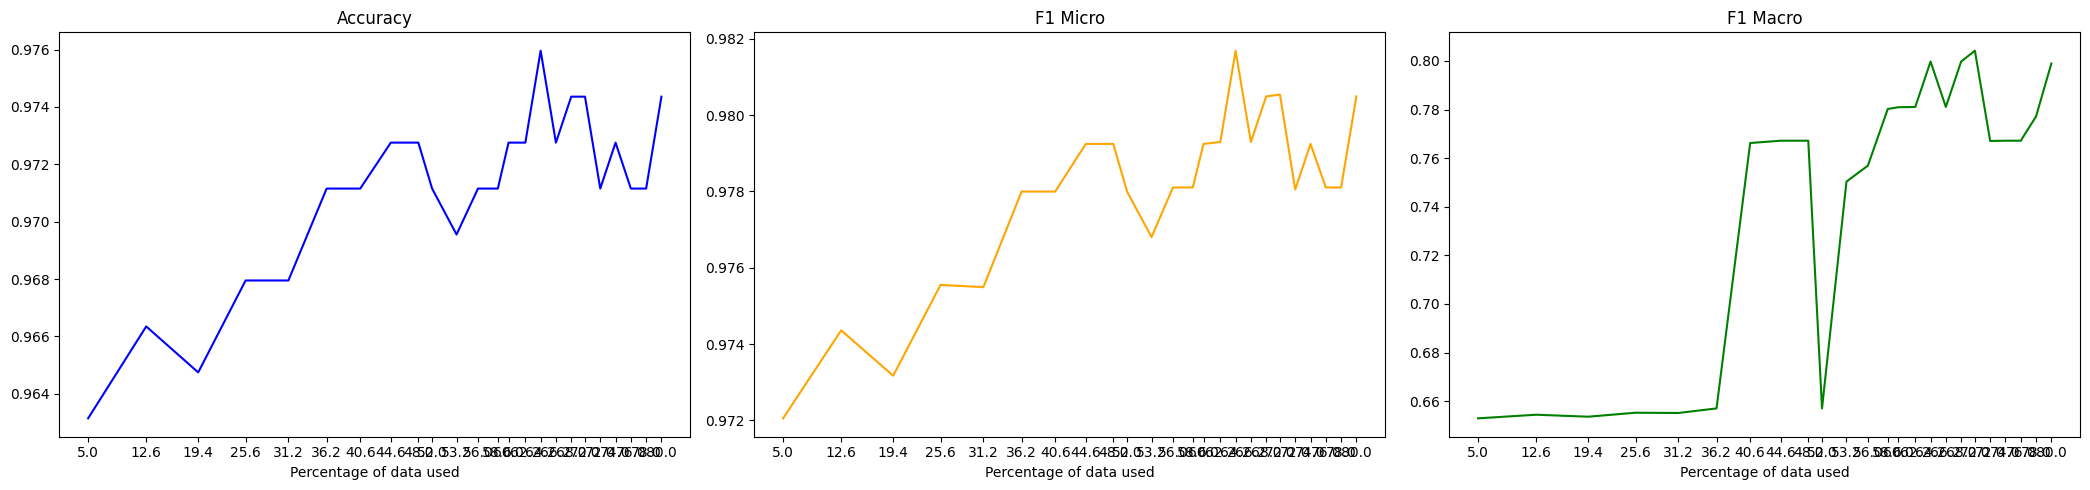

In [ ]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6264, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3387, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2128, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2886, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1748, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1776, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1499, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1806, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5082, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.264, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1949, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1813, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1648, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1419, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.116, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1498, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4208, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2089, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1991, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1824, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1894, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1562, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1406, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 8/10, Train Loss: 0.0936, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6535
Epoch 9/10, Train Loss: 0.1027, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6525
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3949, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1928, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1869, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1493, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1664, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1351, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1399, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 8/10, Train Loss: 0.1032, Accuracy: 0.9631, F1 Micro: 0.9715, F1 Macro: 0.6517
Epoch 9/10, Train Loss: 0.0998, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6539
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3478, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1965, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1862, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1839, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 5/10, Train Loss: 0.1405, Accuracy: 0.9567, F1 Micro: 0.9663, F1 Macro: 0.6473
Epoch 6/10, Train Loss: 0.1271, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.6538
Epoch 7/10, Train Loss: 0.0994, Accuracy: 0.9631, F1 Micro: 0.9715, F1 Macro: 0.6517
Epoch 8/10, Train Loss: 0.0895, Accuracy: 0.9615, F1 Micro: 0.9703, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0711, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.655
Epoch 10/10, Train Loss: 0.0529, Accuracy: 0.9631, F1 Micro: 0.9716, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3456, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1949, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1739, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1574, Accuracy: 0.9535, F1 Micro: 0.9639, F1 Macro: 0.6456
Epoch 5/10, Train Loss: 0.1501, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6519
Epoch 6/10, Train Loss: 0.1199, Accuracy: 0.9567, F1 Micro: 0.9664, F1 Macro: 0.6476
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0842, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6528
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0586, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.056, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7289
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3428, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1919, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1686, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1723, Accuracy: 0.9615, F1 Micro: 0.9703, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1472, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Epoch 6/10, Train Loss: 0.1167, Accuracy: 0.9615, F1 Micro: 0.9701, F1 Macro: 0.6505
Epoch 7/10, Train Loss: 0.0832, Accuracy: 0.9599, F1 Micro: 0.969, F1 Macro: 0.7155
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.756
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3133, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1962, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1715, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1641, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.1168, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6519
Epoch 6/10, Train Loss: 0.1188, Accuracy: 0.9599, F1 Micro: 0.9689, F1 Macro: 0.6497
Epoch 7/10, Train Loss: 0.0836, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0707, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7226
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.6568
Epoch 10/10, Train Loss: 0.0392, Accuracy: 0.9696, F1 Micro: 0.9767, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2912, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2032, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1701, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1638, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 5/10, Train Loss: 0.1384, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7093
Epoch 6/10, Train Loss: 0.1109, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7175
Epoch 7/10, Train Loss: 0.0609, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6523
Epoch 8/10, Train Loss: 0.0636, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7529
Epoch 9/10, Train Loss: 0.0427, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7651
Epoch 10/10, Train Loss: 0.0373, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7643
Iteration 241: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3108, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1877, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.158, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 4/10, Train Loss: 0.1509, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1155, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7651
Epoch 6/10, Train Loss: 0.1035, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.6558
Epoch 7/10, Train Loss: 0.0637, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.763
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0508, Accuracy: 0.9728, F1 Micro: 0.9791, F1 Macro: 0.767
Epoch 9/10, Train Loss: 0.0301, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.6549
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0378, Accuracy: 0.9728, F1 Micro: 0.9792, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2826, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1908, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.189, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1578, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.1325, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6552
Epoch 6/10, Train Loss: 0.1057, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7459
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Epoch 8/10, Train Loss: 0.0526, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7988
Epoch 10/10, Train Loss: 0.029, Accuracy: 0.9663, F1 Micro: 0.9742, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2949, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1684, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1568, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1596, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1138, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 6/10, Train Loss: 0.098, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.776
Epoch 7/10, Train Loss: 0.063, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.775
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7969
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.7177
Epoch 10/10, Train Loss: 0.0304, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2776, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1857, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.16, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1474, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1002, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7217
Epoch 6/10, Train Loss: 0.0699, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7948
Epoch 7/10, Train Loss: 0.0474, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7642
Epoch 8/10, Train Loss: 0.0367, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0343, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7663
Epoch 10/10, Train Loss: 0.0273, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2767, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1841, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1778, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1398, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7212
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1097, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Epoch 6/10, Train Loss: 0.0863, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7948
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0621, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 8/10, Train Loss: 0.0398, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.7601
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Epoch 10/10, Train Loss: 0.0283, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2702, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1965, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.166, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1368, Accuracy: 0.9615, F1 Micro: 0.9701, F1 Macro: 0.6504
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1233, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0925, Accuracy: 0.9679, F1 Micro: 0.9752, F1 Macro: 0.7944
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0633, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 8/10, Train Loss: 0.0495, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7651
Epoch 9/10, Train Loss: 0.037, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2731, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1781, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1851, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1518, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1028, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0844, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0631, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 8/10, Train Loss: 0.0414, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7958
Epoch 9/10, Train Loss: 0.0425, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7959
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2699, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1749, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1794, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1409, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1091, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.085, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0491, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8042
Epoch 8/10, Train Loss: 0.038, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 9/10, Train Loss: 0.0314, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7959
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2556, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1924, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1681, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1517, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.7194
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1084, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7999
Epoch 6/10, Train Loss: 0.0769, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Epoch 7/10, Train Loss: 0.0668, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7958
Epoch 8/10, Train Loss: 0.0396, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 9/10, Train Loss: 0.0318, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.8163
Epoch 10/10, Train Loss: 0.0238, Accuracy: 0.9696, F1 Micro: 0.9768, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2508, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1672, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1871, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1433, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7939
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0973, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7672
Epoch 6/10, Train Loss: 0.0735, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0625, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.045, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch 9/10, Train Loss: 0.034, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2694, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1686, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1594, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1304, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7198
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1029, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7553
Epoch 6/10, Train Loss: 0.0802, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7759
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0537, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7967
Epoch 8/10, Train Loss: 0.0418, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7752
Epoch 9/10, Train Loss: 0.0283, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7632
Epoch 10/10, Train Loss: 0.0216, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2545, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1776, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1639, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1274, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7543
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1045, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7561
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0695, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0463, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.768
Epoch 8/10, Train Loss: 0.0364, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.026, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.768
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2654, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.167, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1612, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1156, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7207
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.087, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7894
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0518, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7998
Epoch 7/10, Train Loss: 0.0433, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7874
Epoch 8/10, Train Loss: 0.0393, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7439
Epoch 9/10, Train Loss: 0.0237, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7771
Epoch 10/10, Train Loss: 0.0244, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2423, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1518, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1592, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1119, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7107
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0919, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0642, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0467, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7893
Epoch 8/10, Train Loss: 0.0376, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.8186
Epoch 9/10, Train Loss: 0.0247, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.801
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2434, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1603, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1511, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1206, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 5/10, Train Loss: 0.0836, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7383
Epoch 6/10, Train Loss: 0.0619, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7773
Epoch 7/10, Train Loss: 0.0336, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 8/10, Train Loss: 0.0334, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7662
Epoch 9/10, Train Loss: 0.0208, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7872
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0166, Accuracy: 0.9744, F1 Micro: 0.9805, F1 

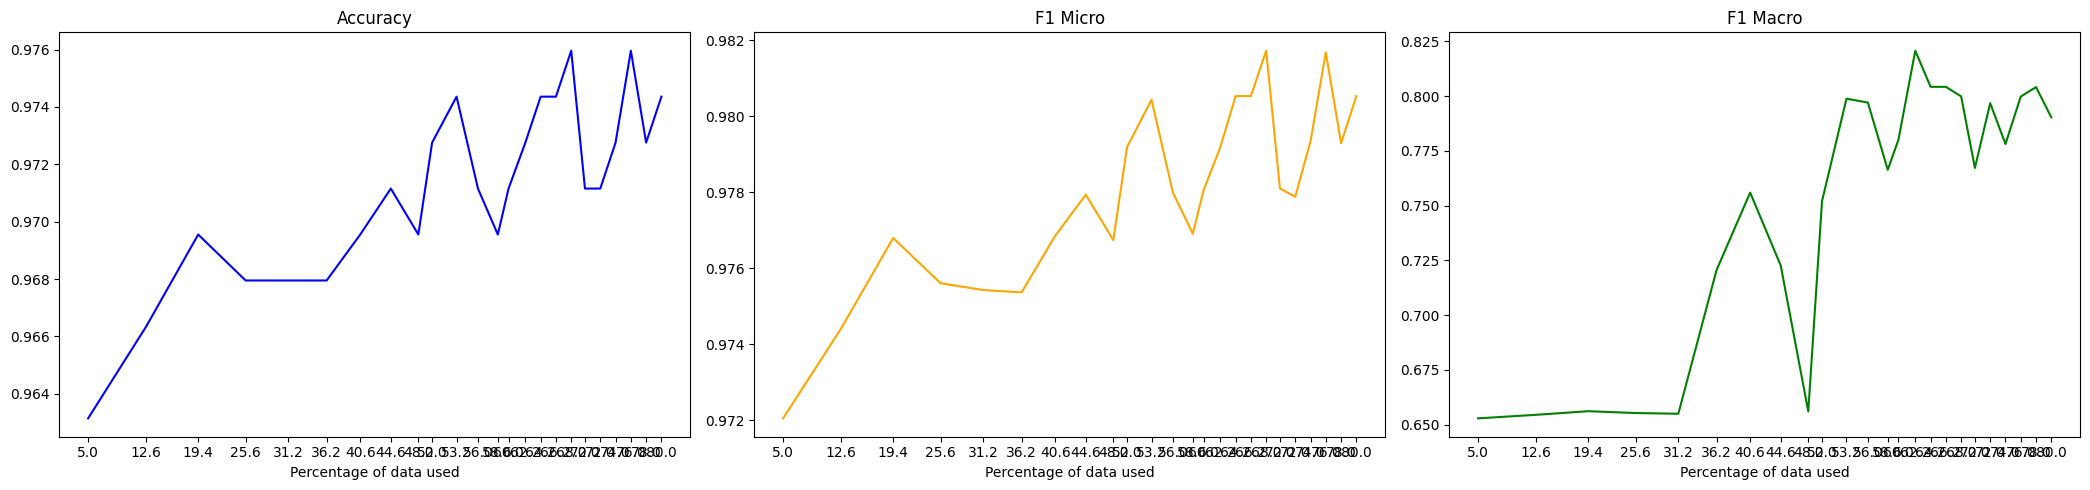

In [19]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5338, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3414, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2451, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2103, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1435, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1557, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1241, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1134, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4479, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2578, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2037, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1825, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1192, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1576, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1491, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1151, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3821, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1876, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1813, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1486, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1318, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1168, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 7/10, Train Loss: 0.1269, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Epoch 8/10, Train Loss: 0.0848, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.6488
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0835, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.6558
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.356, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2213, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1921, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.175, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1257, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1676, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6539
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.114, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 8/10, Train Loss: 0.0911, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.654
Epoch 9/10, Train Loss: 0.0753, Accuracy: 0.9615, F1 Micro: 0.9703, F1 Macro: 0.6509
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.342, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2178, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1855, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1453, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1306, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.1121, Accuracy: 0.9583, F1 Micro: 0.9678, F1 Macro: 0.649
Epoch 7/10, Train Loss: 0.1047, Accuracy: 0.9503, F1 Micro: 0.9613, F1 Macro: 0.6434
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.076, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6535
Epoch 9/10, Train Loss: 0.053, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.651
Epoch 10/10, Train Loss: 0.049, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3134, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1922, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1792, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.156, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1552, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1008, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.722
Epoch 7/10, Train Loss: 0.0893, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.719
Epoch 8/10, Train Loss: 0.078, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 10/10, Train Loss: 0.0476, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3033, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1731, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1684, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1628, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 5/10, Train Loss: 0.129, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.0861, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 7/10, Train Loss: 0.0852, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Epoch 8/10, Train Loss: 0.0584, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.652
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Epoch 10/10, Train Loss: 0.0383, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6512
Iteration 203: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2952, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1686, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1673, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1581, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1468, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 6/10, Train Loss: 0.091, Accuracy: 0.9551, F1 Micro: 0.9652, F1 Macro: 0.6467
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9599, F1 Micro: 0.969, F1 Macro: 0.6499
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0582, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.9599, F1 Micro: 0.9691, F1 Macro: 0.65
Epoch 10/10, Train Loss: 0.0398, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.284, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1801, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1637, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1557, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 5/10, Train Loss: 0.1394, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0804, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 7/10, Train Loss: 0.0735, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0454, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7209
Epoch 9/10, Train Loss: 0.0397, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6539
Epoch 10/10, Train Loss: 0.033, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2814, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1779, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1695, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1764, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1461, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1294, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 7/10, Train Loss: 0.0791, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7611
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7198
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.035, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7217
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2838, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1705, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1684, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1316, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 5/10, Train Loss: 0.115, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.0735, Accuracy: 0.9599, F1 Micro: 0.9689, F1 Macro: 0.6497
Epoch 8/10, Train Loss: 0.0576, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6529
Epoch 9/10, Train Loss: 0.048, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7291
Epoch 10/10, Train Loss: 0.0362, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7449
Iteration 266: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2665, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1815, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1803, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1362, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1387, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.657
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7227
Epoch 7/10, Train Loss: 0.0836, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 8/10, Train Loss: 0.0469, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7228
Epoch 9/10, Train Loss: 0.0403, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7292
Epoch 10/10, Train Loss: 0.0354, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2626, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1667, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1487, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1433, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1251, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7226
Epoch 6/10, Train Loss: 0.0914, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7217
Epoch 7/10, Train Loss: 0.0643, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0463, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.6569
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2555, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1931, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.154, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1285, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 5/10, Train Loss: 0.1181, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.7278
Epoch 6/10, Train Loss: 0.069, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7486
Epoch 7/10, Train Loss: 0.0617, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7496
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0522, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7505
Epoch 9/10, Train Loss: 0.0342, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0325, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2762, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1755, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1673, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1466, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 5/10, Train Loss: 0.1134, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.655
Epoch 6/10, Train Loss: 0.0648, Accuracy: 0.9615, F1 Micro: 0.9702, F1 Macro: 0.7597
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0555, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.766
Epoch 8/10, Train Loss: 0.0436, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7175
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7959
Epoch 10/10, Train Loss: 0.0309, Accuracy: 0.9696, F1 Micro: 0.9768, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2647, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1554, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1634, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1391, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1215, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 6/10, Train Loss: 0.0736, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0599, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7653
Epoch 8/10, Train Loss: 0.0507, Accuracy: 0.9679, F1 Micro: 0.9753, F1 Macro: 0.7946
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0332, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2496, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1767, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1581, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1292, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.6488
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1061, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0682, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7802
Epoch 7/10, Train Loss: 0.0453, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0497, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 9/10, Train Loss: 0.0282, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7577
Epoch 10/10, Train Loss: 0.0306, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2553, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1728, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.166, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1456, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6519
Epoch 5/10, Train Loss: 0.1034, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.761
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0798, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.7936
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0532, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0354, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.8208
Epoch 9/10, Train Loss: 0.0322, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 10/10, Train Loss: 0.0258, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2622, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1517, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.164, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1344, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1084, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 6/10, Train Loss: 0.0641, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7541
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0416, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 8/10, Train Loss: 0.0452, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7538
Epoch 9/10, Train Loss: 0.0318, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7779
Epoch 10/10, Train Loss: 0.0194, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2467, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1582, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1571, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1359, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1064, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7672
Epoch 6/10, Train Loss: 0.0702, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7956
Epoch 7/10, Train Loss: 0.048, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7802
Epoch 8/10, Train Loss: 0.0454, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.78
Epoch 9/10, Train Loss: 0.0348, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7639
Epoch 10/10, Train Loss: 0.0265, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2288, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1698, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1517, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1276, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.11, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 6/10, Train Loss: 0.0692, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 7/10, Train Loss: 0.0475, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 8/10, Train Loss: 0.0406, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7894
Epoch 9/10, Train Loss: 0.0258, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7811
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0286, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2429, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1629, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1617, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1457, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 5/10, Train Loss: 0.1108, Accuracy: 0.9567, F1 Micro: 0.9664, F1 Macro: 0.6476
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0737, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7649
Epoch 7/10, Train Loss: 0.0583, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7546
Epoch 8/10, Train Loss: 0.0404, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.8177
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0324, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8198
Epoch 10/10, Train Loss: 0.0242, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2432, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1656, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1649, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1298, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.657
Epoch 5/10, Train Loss: 0.0947, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7656
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0645, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7884
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0439, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.805
Epoch 8/10, Train Loss: 0.0395, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7587
Epoch 9/10, Train Loss: 0.0322, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7949
Epoch 10/10, Train Loss: 0.0237, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2417, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1674, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1419, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 4/10, Train Loss: 0.1472, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Epoch 5/10, Train Loss: 0.0939, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.7275
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0713, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7998
Epoch 7/10, Train Loss: 0.0503, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7819
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0363, Accuracy: 0.9776, F1 Micro: 0.9829, F1 Macro: 0.8006
Epoch 9/10, Train Loss: 0.0224, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7819
Epoch 10/10, Train Loss: 0.0218, Accuracy: 0.9744, F1 Micro: 0.9805, F1

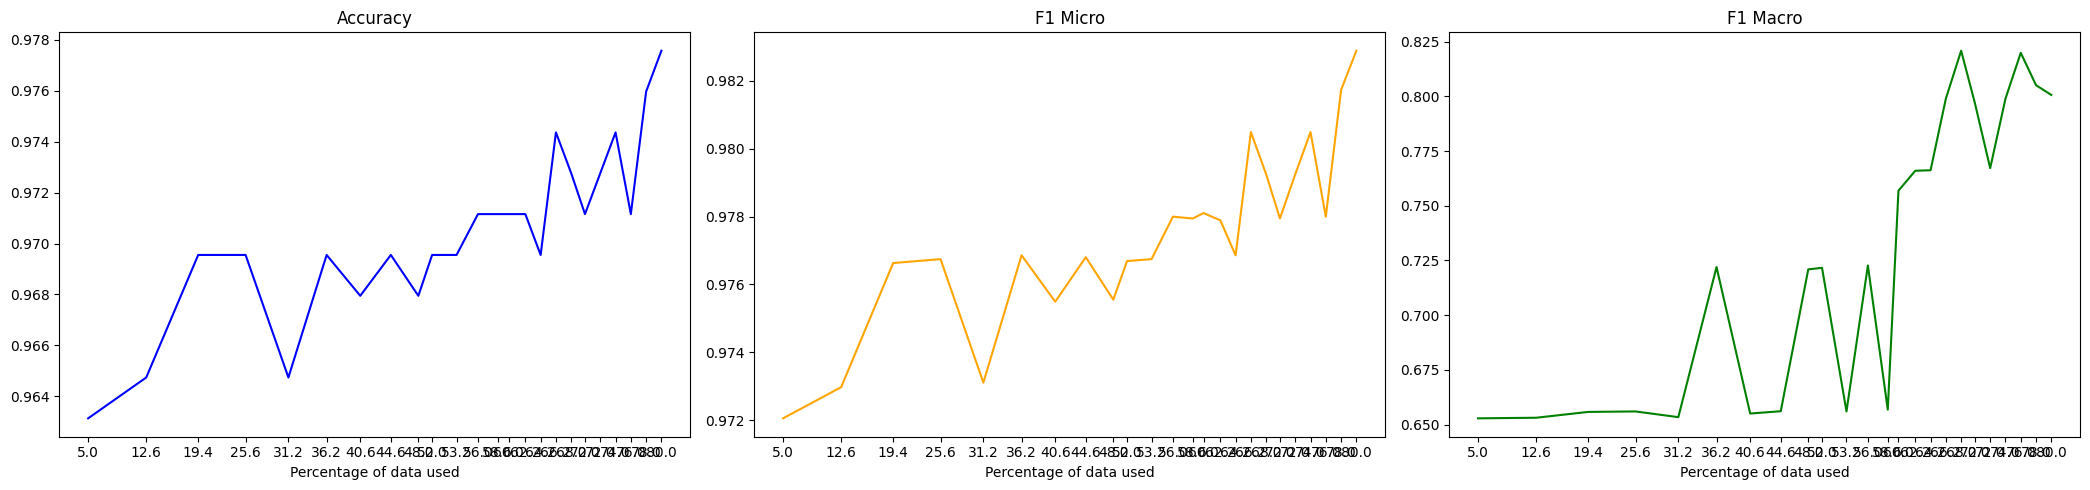

In [20]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5222, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3348, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2357, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1843, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1554, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1788, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1769, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1621, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4326, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2784, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2206, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1911, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2193, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1658, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1897, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.17, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.348, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1993, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.186, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.155, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.204, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1692, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1842, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1303, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 9/10, Train Loss: 0.1285, Accuracy: 0.9567, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3285, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.212, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1998, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1787, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.222, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1486, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1502, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 8/10, Train Loss: 0.1412, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.652
Epoch 9/10, Train Loss: 0.0867, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7172
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3296, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2192, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2186, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2085, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1785, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6489
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1893, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 7/10, Train Loss: 0.1276, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1209, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 9/10, Train Loss: 0.0818, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7212
Epoch 10/10, Train Loss: 0.0542, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3302, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.189, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2121, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1809, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1825, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.1618, Accuracy: 0.9535, F1 Micro: 0.9639, F1 Macro: 0.6456
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.123, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7647
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0801, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7513
Epoch 9/10, Train Loss: 0.0762, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.779
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3096, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2137, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.201, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1829, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1933, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 6/10, Train Loss: 0.1335, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1014, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7208
Epoch 8/10, Train Loss: 0.077, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.75
Epoch 9/10, Train Loss: 0.058, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7076
Epoch 10/10, Train Loss: 0.0447, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2803, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1946, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1987, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1805, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1701, Accuracy: 0.9135, F1 Micro: 0.9297, F1 Macro: 0.6103
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.134, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7446
Epoch 7/10, Train Loss: 0.0909, Accuracy: 0.9551, F1 Micro: 0.9659, F1 Macro: 0.7389
Epoch 8/10, Train Loss: 0.0734, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7556
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7744
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2877, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1871, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1936, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1886, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1515, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7488
Epoch 6/10, Train Loss: 0.1062, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.775
Epoch 7/10, Train Loss: 0.0761, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7172
Epoch 8/10, Train Loss: 0.0531, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.7401
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7644
Epoch 10/10, Train Loss: 0.0328, Accuracy: 0.9615, F1 Micro: 0.9709, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2739, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2119, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.199, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1781, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1453, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Epoch 6/10, Train Loss: 0.122, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7635
Epoch 7/10, Train Loss: 0.0738, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.7951
Epoch 8/10, Train Loss: 0.0591, Accuracy: 0.9471, F1 Micro: 0.9595, F1 Macro: 0.729
Epoch 9/10, Train Loss: 0.044, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7625
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0403, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2653, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.184, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1652, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1727, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1138, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7514
Epoch 6/10, Train Loss: 0.0883, Accuracy: 0.9535, F1 Micro: 0.9641, F1 Macro: 0.7557
Epoch 7/10, Train Loss: 0.0675, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7912
Epoch 8/10, Train Loss: 0.0492, Accuracy: 0.9519, F1 Micro: 0.9633, F1 Macro: 0.7251
Epoch 9/10, Train Loss: 0.0374, Accuracy: 0.9551, F1 Micro: 0.9656, F1 Macro: 0.758
Epoch 10/10, Train Loss: 0.032, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.7403
Iteration 266: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2641, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1679, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1788, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.159, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 5/10, Train Loss: 0.1287, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7293
Epoch 6/10, Train Loss: 0.0954, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7968
Epoch 7/10, Train Loss: 0.0662, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7834
Epoch 8/10, Train Loss: 0.0431, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7934
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7987
Epoch 10/10, Train Loss: 0.026, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7977
Iteration 280: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2826, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1808, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1611, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1593, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1325, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7656
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.103, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7765
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0647, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7765
Epoch 8/10, Train Loss: 0.0506, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7349
Epoch 9/10, Train Loss: 0.0378, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7617
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2361, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1826, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.165, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1394, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6519
Epoch 6/10, Train Loss: 0.0966, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7553
Epoch 7/10, Train Loss: 0.0562, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7423
Epoch 8/10, Train Loss: 0.0435, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7253
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7533
Epoch 10/10, Train Loss: 0.0261, Accuracy: 0.9599, F1 Micro: 0.9693, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2399, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.181, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1762, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 5/10, Train Loss: 0.109, Accuracy: 0.9631, F1 Micro: 0.9715, F1 Macro: 0.7608
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7464
Epoch 7/10, Train Loss: 0.0631, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.776
Epoch 8/10, Train Loss: 0.0424, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7646
Epoch 9/10, Train Loss: 0.0308, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.7335
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0263, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2473, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1745, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.188, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1445, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7093
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1174, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7971
Epoch 6/10, Train Loss: 0.0863, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.762
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0511, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.8034
Epoch 8/10, Train Loss: 0.0365, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.763
Epoch 9/10, Train Loss: 0.0295, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.817
Epoch 10/10, Train Loss: 0.0235, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2602, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1804, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1708, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1378, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.7369
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1161, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7949
Epoch 6/10, Train Loss: 0.0764, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.8163
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0472, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.8211
Epoch 8/10, Train Loss: 0.0373, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7733
Epoch 9/10, Train Loss: 0.0306, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7827
Epoch 10/10, Train Loss: 0.0248, Accuracy: 0.9647, F1 Micro: 0.9733, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2543, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1663, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1721, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1266, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 5/10, Train Loss: 0.1104, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0909, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7736
Epoch 7/10, Train Loss: 0.053, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.7524
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0307, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7655
Epoch 9/10, Train Loss: 0.0229, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7557
Epoch 10/10, Train Loss: 0.0213, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2397, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1928, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1655, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1307, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1083, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0744, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7664
Epoch 7/10, Train Loss: 0.0477, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7453
Epoch 8/10, Train Loss: 0.0375, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7532
Epoch 9/10, Train Loss: 0.0306, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7557
Epoch 10/10, Train Loss: 0.0187, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2389, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1722, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1568, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1346, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7656
Epoch 5/10, Train Loss: 0.1034, Accuracy: 0.9583, F1 Micro: 0.9688, F1 Macro: 0.7294
Epoch 6/10, Train Loss: 0.0711, Accuracy: 0.9663, F1 Micro: 0.9747, F1 Macro: 0.7757
Epoch 7/10, Train Loss: 0.0523, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.7458
Epoch 8/10, Train Loss: 0.0344, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7545
Epoch 9/10, Train Loss: 0.0281, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7546
Epoch 10/10, Train Loss: 0.0213, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.8478
Iteration 360: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2246, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1747, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1587, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1379, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.787
Epoch 5/10, Train Loss: 0.1008, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.762
Epoch 6/10, Train Loss: 0.0624, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7546
Epoch 7/10, Train Loss: 0.0435, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.7645
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0287, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8042
Epoch 9/10, Train Loss: 0.0252, Accuracy: 0.9663, F1 Micro: 0.9747, F1 Macro: 0.8245
Epoch 10/10, Train Loss: 0.0177, Accuracy: 0.9599, F1 Micro: 0.9695, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2404, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1785, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1598, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.146, Accuracy: 0.9535, F1 Micro: 0.9638, F1 Macro: 0.6454
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1094, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7635
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0689, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7783
Epoch 7/10, Train Loss: 0.0544, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7557
Epoch 8/10, Train Loss: 0.0328, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7515
Epoch 9/10, Train Loss: 0.0264, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.744
Epoch 10/10, Train Loss: 0.0237, Accuracy: 0.9615, F1 Micro: 0.9707, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2165, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1562, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1526, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1109, Accuracy: 0.9663, F1 Micro: 0.9747, F1 Macro: 0.7749
Epoch 5/10, Train Loss: 0.0824, Accuracy: 0.9599, F1 Micro: 0.9689, F1 Macro: 0.7893
Epoch 6/10, Train Loss: 0.0678, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7949
Epoch 7/10, Train Loss: 0.0356, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.762
Epoch 8/10, Train Loss: 0.0326, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7734
Epoch 9/10, Train Loss: 0.0182, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7754
Epoch 10/10, Train Loss: 0.0156, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8401
Iteration 390: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.22, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1745, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1472, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1277, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7633
Epoch 5/10, Train Loss: 0.0954, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7409
Epoch 6/10, Train Loss: 0.0653, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.7578
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0417, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7502
Epoch 8/10, Train Loss: 0.0306, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.8367
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.028, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.9133
Epoch 10/10, Train Loss: 0.0154, Accuracy

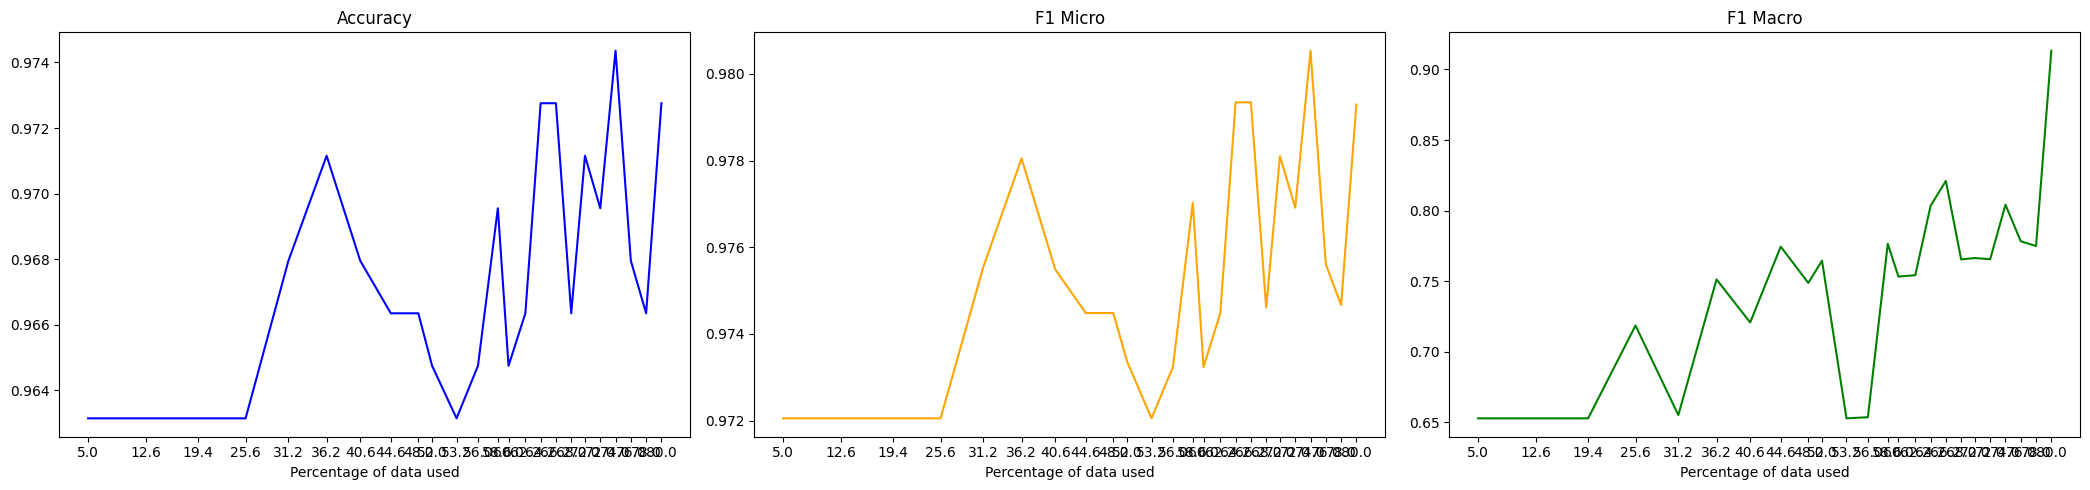

In [21]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5634, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.337, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.281, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2662, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.207, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2021, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1693, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2011, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4902, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2741, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2617, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2665, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2125, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1727, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1681, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1227, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3861, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2526, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1824, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1905, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1571, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.165, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1374, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 8/10, Train Loss: 0.0894, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1025, Accuracy: 0.9663, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3712, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2199, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2143, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1854, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1662, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1639, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1231, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 8/10, Train Loss: 0.1415, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 9/10, Train Loss: 0.1009, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3491, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2246, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2043, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.167, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1541, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1422, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 7/10, Train Loss: 0.1108, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Epoch 8/10, Train Loss: 0.1088, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6502
Epoch 9/10, Train Loss: 0.0854, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3271, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2144, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2074, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 5/10, Train Loss: 0.144, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.6549
Epoch 6/10, Train Loss: 0.1633, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1583, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 8/10, Train Loss: 0.1064, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0861, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7219
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3106, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2347, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2038, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1711, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 5/10, Train Loss: 0.1586, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 6/10, Train Loss: 0.1113, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6512
Epoch 7/10, Train Loss: 0.0874, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7501
Epoch 8/10, Train Loss: 0.0828, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7215
Epoch 9/10, Train Loss: 0.0614, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7079
Epoch 10/10, Train Loss: 0.0464, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.71
Iteration 203: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2845, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2081, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1656, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1619, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1457, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.1361, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 7/10, Train Loss: 0.1032, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.754
Epoch 8/10, Train Loss: 0.0729, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7423
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0537, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7664
Epoch 10/10, Train Loss: 0.0379, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2937, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2143, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1677, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1767, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.657
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.111, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7207
Epoch 8/10, Train Loss: 0.0674, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7177
Epoch 9/10, Train Loss: 0.0463, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Epoch 10/10, Train Loss: 0.0376, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2668, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1654, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.175, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1553, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.657
Epoch 6/10, Train Loss: 0.1128, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 7/10, Train Loss: 0.092, Accuracy: 0.9551, F1 Micro: 0.9665, F1 Macro: 0.7197
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0758, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7673
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 10/10, Train Loss: 0.0341, Accuracy: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2851, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2065, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1556, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 4/10, Train Loss: 0.1647, Accuracy: 0.9535, F1 Micro: 0.9637, F1 Macro: 0.6452
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1575, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7212
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1005, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7653
Epoch 7/10, Train Loss: 0.0663, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7557
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0621, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7561
Epoch 9/10, Train Loss: 0.043, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7661
Epoch 10/10, Train Loss: 0.0381, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2715, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1942, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1865, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1624, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1128, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0831, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7971
Epoch 7/10, Train Loss: 0.0695, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7623
Epoch 8/10, Train Loss: 0.044, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7615
Epoch 9/10, Train Loss: 0.036, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7484
Epoch 10/10, Train Loss: 0.0359, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.274, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1987, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1728, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1583, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 5/10, Train Loss: 0.1409, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 6/10, Train Loss: 0.0909, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 7/10, Train Loss: 0.0554, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7484
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7939
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7386
Epoch 10/10, Train Loss: 0.0283, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7578
Iteration 293: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2515, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1946, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1697, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1424, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.1271, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0986, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 7/10, Train Loss: 0.0692, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.752
Epoch 8/10, Train Loss: 0.0449, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 9/10, Train Loss: 0.0331, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7376
Epoch 10/10, Train Loss: 0.0327, Accuracy: 0.9647, F1 Micro: 0.9733, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2554, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1775, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1571, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1517, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 5/10, Train Loss: 0.1331, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7484
Epoch 6/10, Train Loss: 0.0721, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.7453
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0524, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7971
Epoch 8/10, Train Loss: 0.0458, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8005
Epoch 9/10, Train Loss: 0.0329, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7745
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.9696, F1 Micro: 0.977, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.26, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1652, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1524, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1457, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.1074, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6525
Epoch 6/10, Train Loss: 0.1018, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0542, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 8/10, Train Loss: 0.0406, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7623
Epoch 9/10, Train Loss: 0.0308, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7791
Epoch 10/10, Train Loss: 0.0256, Accuracy: 0.9663, F1 Micro: 0.9747, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2684, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1857, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1685, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1472, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 5/10, Train Loss: 0.1121, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7534
Epoch 6/10, Train Loss: 0.0861, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.763
Epoch 7/10, Train Loss: 0.056, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7484
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.043, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 9/10, Train Loss: 0.0242, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7773
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0263, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2464, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.174, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1551, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1432, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1051, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0759, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7973
Epoch 7/10, Train Loss: 0.0563, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0428, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.8226
Epoch 9/10, Train Loss: 0.0351, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7568
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.231, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.179, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1596, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1453, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1074, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 6/10, Train Loss: 0.0702, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7765
Epoch 7/10, Train Loss: 0.055, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7441
Epoch 8/10, Train Loss: 0.0332, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7864
Epoch 9/10, Train Loss: 0.0309, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 10/10, Train Loss: 0.0248, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2444, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1653, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1575, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1535, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1252, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7105
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0713, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7794
Epoch 7/10, Train Loss: 0.0574, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7477
Epoch 8/10, Train Loss: 0.0333, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7493
Epoch 9/10, Train Loss: 0.0252, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7532
Epoch 10/10, Train Loss: 0.0251, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2327, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1688, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1684, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1608, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 5/10, Train Loss: 0.0975, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0778, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 7/10, Train Loss: 0.0519, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.8024
Epoch 8/10, Train Loss: 0.0339, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7876
Epoch 9/10, Train Loss: 0.0251, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8023
Epoch 10/10, Train Loss: 0.0229, Accuracy: 0.9679, F1 Micro: 0.9758, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2468, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1497, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1524, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1356, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1132, Accuracy: 0.9647, F1 Micro: 0.9735, F1 Macro: 0.7506
Epoch 6/10, Train Loss: 0.0747, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7501
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0489, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7875
Epoch 8/10, Train Loss: 0.0263, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0306, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7893
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2391, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1674, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1428, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 4/10, Train Loss: 0.1167, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 5/10, Train Loss: 0.1049, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7646
Epoch 6/10, Train Loss: 0.0608, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.7144
Epoch 7/10, Train Loss: 0.0402, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7493
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0357, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7763
Epoch 9/10, Train Loss: 0.0241, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7577
Epoch 10/10, Train Loss: 0.0234, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7791
Iteration 390: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2377, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1711, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1462, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1278, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0956, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Epoch 6/10, Train Loss: 0.0582, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7951
Epoch 7/10, Train Loss: 0.0468, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7646
Epoch 8/10, Train Loss: 0.0321, Accuracy: 0.9567, F1 Micro: 0.9675, F1 Macro: 0.7319
Epoch 9/10, Train Loss: 0.0292, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7384
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0179, Accu

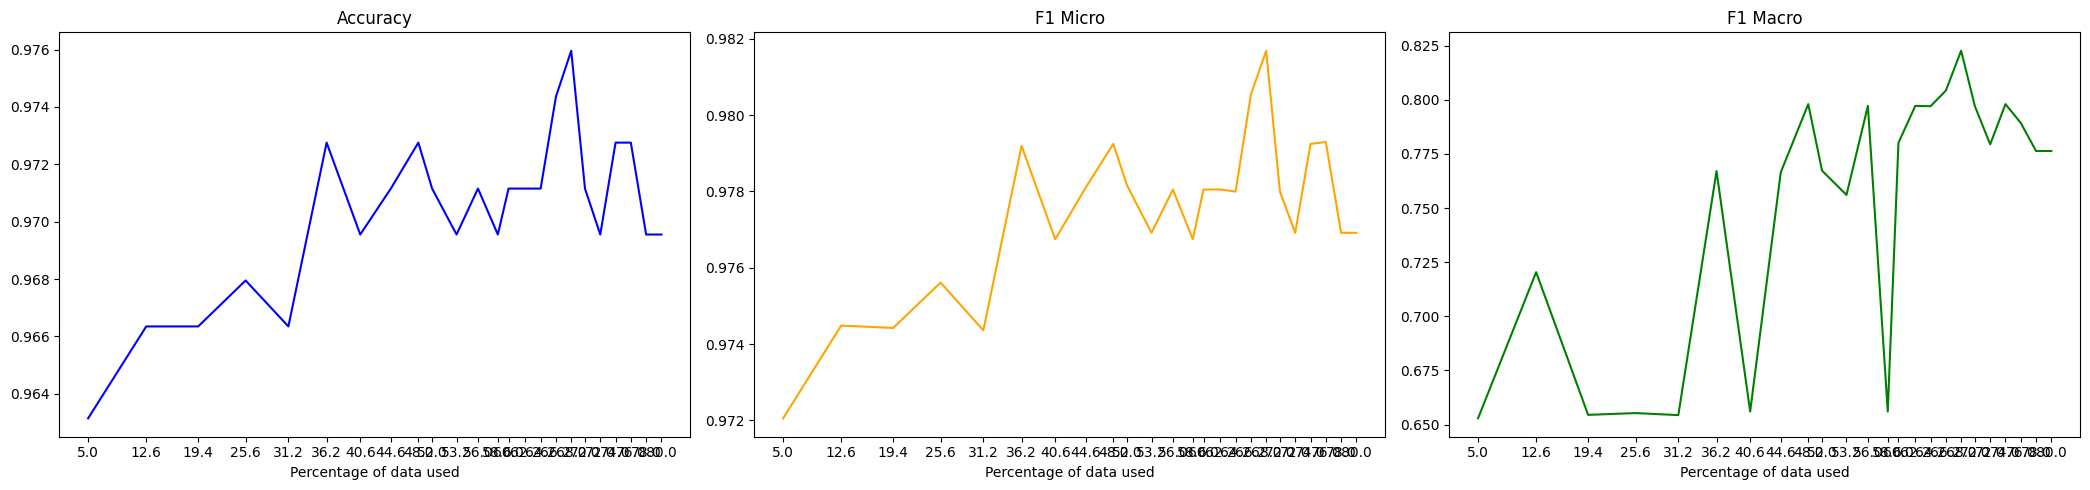

In [22]:
active_learning(seeds[4], 4)